In [1]:
import matplotlib.pyplot as plt # for plotting maps
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
from functools import reduce
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
import re # for some fun processing
import os # because we are storing shapefiles in a few different dirs
import pickle as pkl

from IPython.display import clear_output

%matplotlib inline

pd.set_option("display.max_rows", 150)
pd.set_option("display.max_columns", 150)
plt.rcParams.update({'figure.max_open_warning': 0})

DATA_PATH = "raw-from-source/"
CRS = 3857

county2shape_cache = {}

if not os.path.exists("county2vest_dicts/"):
    os.mkdir("county2vest_dicts")

/Users/SamSpinner/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Rough Table of Contents:

1. Documentation is shown, complete with links to all sources from which data was donwloaded. 
2. Election results are uploaded, pivoted, and merged with VEST. 
3. All election results are validated. 
4. Shapefiles are uploaded, ran through 3 functions assigning raw shapefiles to VEST precincts. 
5. 53 out of CO's 64 counties' shapefiles are validated in one cell. 
6. The 11 remaining shapefiles are validated in their own cell with special adjustments needed. 
7. Las Animas county has undergone too much processing to validate. 
8. Summary begins - reiteration of election data validation, stats on geometry differences between VEST and the raw data. 
9. All VEST precincts for which there was a difference in area > 1 km^2 are listed and plotted. 







### **General Summary**

#### VEST Documentation

----

Election results from the Colorado Secretary of State (https://www.sos.state.co.us/pubs/elections/Results/Archives.html)
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. The following counties used shapefiles sourced from the respective county governments instead: Adams, Arapahoe, Boulder, Delta, Denver, Douglas, El Paso, Fremont, Garfield, Gilpin, Jefferson, La Plata, Larimer, Mesa, Pitkin, Pueblo, Summit, Weld.

Las Animas County precinct assignments in the voter file differ markedly from both the Census VTD boundaries and from maps received from the county. All precincts were revised to match the geocoded voter file and the list of districts assigned to precinct splits. As appropriate, precinct boundaries were revised using Census blocks, the Trinidad municipal boundary shapefile, school district or fire district boundaries, and the parcel shapefile from the Las Animas County Assessor.

The following additional revisions were made to match the 2018 precinct boundaries:

Logan: Align Sterling City precincts with city limits
Montezuma: Precincts renumbered to match county maps
Otero: Align La Junta City precincts with county maps
Prowers: All precincts adjusted to match county maps
Rio Grande: Adjust Precincts 2/3 to match county maps


#### VEST data

----

VEST data files include:  

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  **co_2018.shp** which has both election results and shapefiles, can be found at the bottom of the page at [this link](https://dataverse.harvard.edu/dataverse/electionscience/?q=colorado+2018+precincts). 


The election data columns reported are:

<font color="Coral">
    

Secretary of State
    
    1. G18SOSRPAT - Paul D. Pate (Republican Party)
    2. G18SOSDDEJ - Deidre DeJear (Democratic Party)
    3. G18SOSLOFE - Jules Ofenbakh (Libertarian Party)
    4. G18SOSOWRI - Write-in Votes
    
Governor
    
    1. G18GOVRREY - Kim Reynolds (Republican Party)   
    2. G18GOVDHUB - Fred Hubbell (Democratic Party)
    3. G18GOVLPOR - Jake Porter (Libertarian Party)
    4. G18GOVOSIE - Gary Siegwarth (Clear Water Party)
    5. G18GOVOWRI - Write-in Votes
    
Attorney General
    
    1. G18ATGDMIL - Tom Miller (Democratic Party)
    2. G18ATGLBAT - Marco Battaglia (Libertarian Party)
    3. G18ATGOWRI - Write-in Votes

Treasurer
    
    1. G18TRERDAV - Jeremy N. Davis (Republican Party)
    2. G18TREDFIT - Michael L. Fitzgerald (Democratic Party)
    3. G18TRELHIR - Timothy Hird (Libertarian Party)
    4. G18TREOWRI - Write-in Votes

    
Auditor
    
    1. G18AUDRMOS - Mary Mosiman (Republican Party)
    2. G18AUDDSAN - Rob Sand (Democratic Party)
    3. G18AUDLPER - Fred Perryman (Libertarian Party)
    4. G18AUDOWRI - Write-in Votes
    

Agriculture Secretary
    
    1. G18AGRRNAI - Mike Naig (Republican Party)
    2. G18AGRDGAN - Tim Gannon (Democratic Party)
    3. G18AGRLSTE - Rick Stewart (Libertarian Party)
    4. G18AGROWRI - Write-in Votes

</font>

#### Raw shapefile data

----

The following counties were reached out to directly for precinct shapefile data. 

Each county used unique data formats, but all of the relevant files can be found in **<font color="Coral"> raw-from-source/county_download/{county name all lowercase}</font>**

**Adams** - data found [here](https://data-adcogov.opendata.arcgis.com/search?q=precinct)

**Arapahoe** - data found [here](https://www.arapahoegov.com/1151/GIS-Data-Download)
 
 
**Boulder** - data found [here](https://opendata-bouldercounty.hub.arcgis.com/datasets/precincts?geometry=-106.243%2C39.904%2C-104.503%2C40.272)

**Delta** - requested data by emailing gis@deltacounty.com, will package shape files and send to us. Email with shapefiles received from Carrie Derco, GIS coordinator for Delta County.

**Denver** - data found [here](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-election-precincts)

**Douglas** - data found [here](https://hub.arcgis.com/datasets/dougco::voter-precincts-1?geometry=-106.172%2C39.162%2C-103.814%2C39.533) 

**El Paso** - received shapefiles from email via GIS director Dwayne Liller (DwayneLiller@elpasoco.com)


**Fremont** - data found [here](https://www.fremontco.com/clerk-and-recorder/elections)

**Garfield** - Update to precinct boundaries explained [here](https://www.garfield-county.com/news/clerk-recorder-2017-precinct-boundaries/). shapefiles received by email from GIS coordinator Andrea Grygo (agrygo@garfield-county.com)

**Gilpin** - shapefiles received via email from County Planner Tami Archer, (tarcher@gilpincounty.org) 

**Jefferson** - data found [here](https://data-jeffersoncounty.opendata.arcgis.com/datasets/county-precinct-1?geometry=-107.581%2C39.151%2C-102.865%2C39.893)

**La Plata** - data found [here](https://www.co.laplata.co.us/services/elections/index.php)

**Larimer** - data found [here](https://www.larimer.org/it/services/gis/digital-data)

**Mesa** - data found [here](https://opendata-mesacounty.hub.arcgis.com/datasets/7dd0dcebc31944ba8eea467c997c3829_15?geometry=-110.582%2C38.559%2C-105.866%2C39.307)

**Pitkin** - data found [here](https://pitkincounty.com/874/Base-Map)

**Pueblo** - requested data from edgis@pueblocounty.us., shapefiles received from Robert Deherrera (robde@pueblocounty.us) 
 
**Summit** - data found [here](https://data-summitcountyco.opendata.arcgis.com/search?groupIds=548c92e5e1af41a09155d6ff7141fba0)

**Weld** - data found [here](https://gishub.weldgov.com/datasets/7205d33baa7d48d285bf08c5e9803213_0?geometry=-106.670%2C40.137%2C-101.954%2C40.867)

##### The remaining counties were taken from the Census Phase 2 data, downloaded from [this link](https://www.census.gov/geo/partnerships/pvs/partnership19v2/st08_co.html). 




#### Raw election results data

----

Most election results were pulled from the [SoS website]
(https://www.sos.state.co.us/pubs/elections/Results/archive2000.html), 
   

All of the data for CO accessed and downloaded between the dates of April 12th and April 16th, 2021. 


### Upload election and VEST data. 

In [2]:
master_vest_df = gp.read_file("raw-from-source/vest/co_2018.shp")
master_sos_df = pd.read_excel("raw-from-source/sos/2018GEPrecinctLevelResults.xlsx")

In [3]:
vest_df = master_vest_df.copy()
vest_df = vest_df.to_crs(CRS)
sos_df = master_sos_df.copy()

sos_df = sos_df[sos_df["Office/Issue/Judgeship"].isin(["Governor", "Secretary of State",
                                                      "Regent Of The University Of Colorado - At Large",
                                                          "Attorney General","Treasurer"])]

sos_df["ID"] = sos_df["County"] + " " + sos_df["Precinct"].astype('str').str.slice(start=4)

print("VEST dims", vest_df.shape)
print("SoS dims", sos_df.shape)

# Let's see if the Precinct codes are unique and match
assert(len(vest_df["PRECINCT"]) == len(vest_df["PRECINCT"].unique()))

VEST dims (3136, 24)
SoS dims (56448, 12)


#### Align VEST and SoS election data by VTDST numbers. 

In [4]:
# can we back out the county from the NAME column from VEST?
vest_df["COUNTY"] = vest_df["NAME"].str.replace(r"[0-9]", "")
vest_df["ID"] = vest_df["COUNTY"] + vest_df["PRECINCT"].str.slice(start=4)

vest_counties = vest_df["NAME"].str.replace(r"[0-9]", "").value_counts()

print("We are expecting 64 counties:")
print(len(vest_counties))

We are expecting 64 counties:
64


<ipython-input-4-3fa517b867a0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  vest_df["COUNTY"] = vest_df["NAME"].str.replace(r"[0-9]", "")
<ipython-input-4-3fa517b867a0>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  vest_counties = vest_df["NAME"].str.replace(r"[0-9]", "").value_counts()


In [5]:
# are going to need to pivot the election data
pivot_df = pd.pivot_table(sos_df, index="ID", columns=["Candidate"], values="Candidate Votes", aggfunc="first")
display(pivot_df.head(6))
print(pivot_df.shape)
print(vest_df.shape)

Candidate,Amanda Campbell,Bill Hammons / Eric Bodenstab,Blake Huber,Brian Watson,Christopher E. Otwell,Dave Young,George Brauchler,Gerald F. Kilpatrick,James K. Treibert,Jared Polis / Dianne Primavera,Jena Griswold,Ken Montera,Lesley Smith,Phil Weiser,Scott Helker / Michele Poague,Walker Stapleton / Lang Sias,Wayne Williams,William F. Robinson III
ID,,,,,,,,,,,,,,,,,,
Adams 001130,8,6,0,87,5,97,88,14,5,103,104,77,104,98,10,83,89,10
Adams 001131,15,9,8,128,9,243,129,16,21,230,244,124,235,237,23,133,123,22
Adams 001132,26,15,5,245,11,521,275,23,32,506,511,238,487,485,26,258,249,29
Adams 001138,13,11,5,273,8,270,279,19,29,278,289,261,251,259,21,273,266,32
Adams 001139,2,3,4,84,3,72,89,8,2,76,73,77,79,68,3,83,85,7
Adams 001140,18,2,1,162,5,218,172,19,17,234,217,158,202,212,24,156,164,14


(3136, 18)
(3136, 26)


#### Convert Candidates to VEST column names

In [6]:
# Let's make a quick conversion from sos names to VEST names
for i in range(100):
    row = pivot_df.iloc[i].copy()
    if (len(row) == len(row.unique())):
        break
        
old_names = pivot_df.iloc[i].sort_values()
old_names = old_names.index

election_cols = [col for col in vest_df if col.startswith("G18")]
new_names = vest_df[vest_df["ID"] == "Adams 001140"].iloc[0][election_cols].sort_values().index

convert_cols = {old : new for old, new in zip(old_names, new_names)}

#### Time to merge

In [7]:
pivot_df.rename(columns=convert_cols, inplace=True)
pivot_df.reset_index(inplace=True)
merged_df = vest_df.merge(pivot_df, how="outer", on="ID")

#### Let's move straight to vote validation baby. 

In [8]:
# Now we can begin some validation on real values, this is exciting. 
# Let's try to verify on a county wide basis 
def validater_row_vect(df, name_column, column_list, verbose=False):
    matching_rows = 0
    different_rows = 0
    
    county_join_cols = (df[name_column]).to_numpy()
    
    # it's because before, we were checking that a row was entirely consistent
    # here, we are double checking a lot
    # so, let's just keep one track of the rows that are messed up
    
    wrong_idxs = np.zeros(len(df))
    for i in column_list:
        left_data = df[i + "_x"].to_numpy()
        right_data = df[i + "_y"].to_numpy()
        
        local_idxs = np.where(left_data != right_data)
        wrong_idxs[local_idxs] = 1
        #print("Wrong idxs", wrong_idxs)
        
    # we are close, we get the same result, but are double adding lots of rows
    different_rows += np.sum(wrong_idxs)
    matching_rows += len(df) - different_rows
    
    diff_list = county_join_cols[np.where(wrong_idxs == 1)]
    diff_counties = list(set([county[:2] for county in diff_list]))
    
    if int(different_rows) != 0 or verbose:
        print("There are ", len(df.index)," total rows")
        print(f"{int(different_rows)} of these rows have election result differences")
        print(f"{int(matching_rows)} of these rows are the same")
        print(diff_list)
        print("")
        
    return (int(different_rows) == 0, diff_list)

interesting_cols = [col[:-2] for col in merged_df if col.endswith("_x")]
print("CO election results are correct?", validater_row_vect(merged_df, "ID", interesting_cols)[0])

CO election results are correct? True


### Shapefile validation. Let's keep track of the geometries that we will ultimately match!

In [9]:
# TODO update documentation for c_field and v_field

# TODO handle the multiple county assignments/no geoms matched problem

def get_county_shapefile(paths, county):
    """
    Quick way to load a shapefile for a specific county. 
    """
    
    if county in county2shape_cache:
        return county2shape_cache[county]
    
    c = county.strip().replace(" ","_").lower()
    path = [p for p in paths if c == p.split('/')[-1]][0]
    file = [f for f in os.listdir(path) if f.endswith('shp')]
    
    if len(file) == 0:
        print(f"No file associated with {county} county")
        raise ValueError()
        
    file = file[0]
    df = gp.read_file(path + "/" + file)
    df = df.to_crs(CRS)
    
    county2shape_cache[county] = df.copy()
    
    return df

def assign_names_by_geoms(vest, raw, v_field, c_field, verbose=False, tolerance=3e-2, 
                              graph=False):
    """
    For use in the case where one is trying to match shapefiles between two 
    GeoDataFrames but the geometries are the only real unique ID shared between
    each file. 
    
    @param vest (GeoDataFrame): VEST data for a single county
    @param raw (GeoDataFrame): either census or locally downloaded shapefiles
                                for a single county
    @param verbose (bool): to print or not to print, that is the question
    @param tolerance (float): ultimately, raw precinct shapefiles are considered to
                                be outside of the VEST precinct shapefile if the difference
                                in area after you subtract overlap between the raw and VEST shapefile 
                                is small. How small, you ask? That's up to ~tolerance~. In testing,
                                if a raw precinct file falls outside of the VEST precinct, the area of 
                                the overlap is on the order of 1e-6. However, there are some cases where 
                                a raw precinct that is largely outside of VEST precinct will nibble away
                                > .001 of the area. As such, the tolerance is set by default to .003. So,
                                if the area overlap between a raw precinct and a VEST precinct is more than
                                .3% of the VEST precinct's area, the raw precinct is mapped to the VEST precinct.
                                    
    
    @return name2vest (dict): mapping of raw IDs to their corresponding NAME field
                                in the vest dataframe. Used to dissolve shapefiles together. 
    
    """
    # To be returned at the end, the bread and butter
    name2vest = defaultdict(set)
    invalid_geoms = set()
    
    
    # This line looks weird, it's just grabbing each row from a 
    # geopandas GeoDataFrame without reverting the row to pandas, 
    # which happens by indexing via .iloc[]
    rows = [vest[vest[v_field] == vest[v_field].iloc[i]] for i in range(len(vest))]

    # aka for precinct in county
    for row in rows:
        vest_name = row[v_field].iloc[0]
        
        if verbose:
            print()
            print(vest_name + " Assign")

            print('-' * 25)
        
        # standardizing index for later comparison
        row.index = [i for i in range(len(row))]
        
        # shapely object
        geom = row["geometry"].iloc[0]
        
        try:
            # Get all geometries that are within or touch the shapely object
            # of the current VEST precinct
            relevant_prcs = raw[(raw["geometry"].intersects(geom))]
            contained_prcs = raw[(raw["geometry"].within(geom))]
            
            # TODO: make this take precedence over the other precincts found
            same_prcs = raw[(raw["geometry"].geom_almost_equals(geom))]

        except:
            # Sometimes the geopandas binary predicates break, not quite sure why
            print(f"{vest_name} will need special attention, invalid geometries")
            invalid_geoms.add(vest_name)
            
        if verbose:
                print("Num relevant prcs", len(relevant_prcs))
                print("Num contained prcs", len(contained_prcs))
                print("Num same_prcs prcs", len(same_prcs))
                print()
        
            
        # to make sure things are working correctly, 
        # plot all precincts we've matched from shapefile
        # that COULD be within the VEST precinct's shapefile
        if graph:
            fig, ax = plt.subplots(1, 2, figsize=(6, 6))
            relevant_prcs.plot(ax=ax[0], color="Coral")

            # draw a red ring of the VEST precinct shape
            # around the shape precincts we have selected
            try:
                ax[0].plot(*geom.exterior.xy, color="red")
            except AttributeError:
                for g in geom.geoms:
                    plt.plot(*g.exterior.xy, color="red")
        
        
        # the shape IDs that will be mapped to VEST name
        keep_names = []
        
        names = relevant_prcs[c_field].to_list()
        names.extend(contained_prcs[c_field].to_list())
        names.extend(same_prcs[c_field].to_list())
        
        # it would be good if we could assign indices to shapefiles?
        for name in list(set(names)):
            
            # again, preserving GeoDataFrame type
            prc = relevant_prcs[relevant_prcs[c_field] == name].copy()
            
            orig_idx = tuple(prc.index.to_list())
            
            if graph:
                prc.plot(ax=ax[0])
            
            # set index to 0
            prc.index = [i for i in range(len(prc))]
            
            # see how much area the raw precinct and VEST precinct share
            area_overlap = gp.overlay(row, prc, how="difference")
            
            if graph:
                ax[0].set_title("overlap")
                
            area_diff = geom.area - area_overlap["geometry"].area.sum()
            percent_diff = area_diff / geom.area
            
            if verbose:
                print(f"{name} percent difference", np.round(percent_diff, 4))
            
            # bug could crop up here, not sure about the change
            if percent_diff > tolerance or name in contained_prcs[c_field].values:
                keep_names.append((name, orig_idx))
                
        just_names = [key[0] for key in keep_names]
        # Plot the raw precincts we have assigned, wrap VEST in red around
        if graph:
            relevant_prcs[relevant_prcs[c_field].isin(just_names)].plot(ax=ax[1])
            
        for name in keep_names:
            name2vest[name].add(vest_name)
        
        if graph:
            try:
                ax[1].plot(*geom.exterior.xy, color="red")
            except AttributeError:
                for g in geom.geoms:
                    plt.plot(*g.exterior.xy, color="red")

            ax[1].set_title("Resulting assignment")
            fig.suptitle(vest_name)
    
        if verbose:
            print()
            print("Num prcs kept", len(keep_names))

    return name2vest, invalid_geoms


def add_merge_column(raw, name2vest, c_field, verbose=False):
    """
    Append a new column to raw, return the updated col?
    """
    
    multiple_assignments = set()
    
    for name, val in name2vest.items():
        if len(val) > 1:
            print(f"{name} has multiple assignments:", val)
            # we may want to add something here, can we expand the size of raw?
            # this could be promising, come back here
            multiple_assignments.add(name)
    
    name_dict = {key[0] : val for key, val in name2vest.items()}
    
    # might be worth duplicating the rows for precincts that are assigned to multiple locations
    raw["MERGE"] = raw[c_field].apply(lambda name: list(name_dict[name])[0] if name in name_dict else name)
    
    if verbose:
        print("Raw dimensions before dissolve:", raw.shape)
        
    # there could also be a bug here, merging combined too much
    raw = raw.dissolve(by="MERGE", aggfunc="first").to_crs(CRS)

    if verbose:
        print("Raw dimensions after dissolve:", raw.shape)
        
    raw.reset_index(inplace=True)
    
    if verbose:
        print(raw["MERGE"].value_counts())
    print()
    return raw, multiple_assignments


def validate_assigned_geoms(vest, raw, invalid_geoms, v_field, c_field, 
                                tolerance=.1, verbose=False):
    """
    After raw shapefiles have been assigned to VEST precincts
    and merged, we can run geom_almost equals. For the precincts
    that come up as unequal, print the difference in area, and if 
    that difference is larger than 0, plot the overlaid version of 
    both raw and precinct maps. 
    
    @param vest (GeoDataFrame): VEST data for a single county
    @param raw (GeoDataFrame): either census or locally downloaded shapefiles
                                for a single county. Should have a "MERGE" column
                                that maps to a vest v_field column.
                                
    @return no_corresponding (set): vest precincts that for some reason did not 
                                    have any raw precincts assigned to them
    """
    labeled_incorrect = set()
    geom_exception = set()
    county = vest["COUNTY"].value_counts().index.to_list()[0]
    valid = True
    for name in vest[v_field].value_counts().index:
        
        if verbose:
            print()
            print(name + " Validate")
            print('-' * 25)
        
        if name in invalid_geoms:
            print(f"Precinct {name} had invalid geometries, look at separately.")
            continue
        
        # Shapefiles that should be assigned to one another
        v_row = vest[vest[v_field] == name]
        # bug could be cropping up here, should check on raw merge
        loc_row = raw[raw["MERGE"] == name]
        
        if verbose:
            print("VEST type", type(v_row))
            print("VEST dims", v_row.shape)
            
            print("Raw type", type(loc_row))
            print("Raw dims", loc_row.shape)
        
        
        # See if the merged shapefiles are equal to VEST
        try:
            geom_equals = v_row["geometry"].geom_almost_equals(loc_row["geometry"], align=False)
        except ValueError:
            print(f"Exception thrown for geom_almost_equals on {name}")
            geom_exception.add(name)
            print()
            continue
            
        # break down the precincts that didn't match 
        if not geom_equals.all():   
            
            v_area = v_row.geometry.area.to_numpy()
            loc_area = loc_row.geometry.area.to_numpy()
            difference = np.round(np.sum(np.abs(v_area - loc_area) / 1e6), 2)

            if difference > tolerance:
                valid = False
                print(f"Geoms reported unequal for {name}")
                print(f"Difference in area is {difference} km^2")
                print()
                
                labeled_incorrect.add(name)
                fig, ax = plt.subplots(1, 3, figsize=(12,4))
                
                type_v = str(type(v_row["geometry"].iloc[0]))
                type_loc = str(type(loc_row["geometry"].iloc[0]))
    
                
                if type_v != "<class 'shapely.geometry.multipolygon.MultiPolygon'>":              
                    v_row.exterior.plot(ax=ax[0], color="Coral")
                    v_row.exterior.plot(ax=ax[2], color="Coral")
                    
                else:
                    for g in v_row["geometry"].iloc[0].geoms:
                        ax[0].plot(*g.exterior.xy, color="Coral")
                        ax[2].plot(*g.exterior.xy, color="Coral")
                        
                
                if type_loc != "<class 'shapely.geometry.multipolygon.MultiPolygon'>":
                    loc_row.exterior.plot(ax=ax[1])
                    loc_row.exterior.plot(ax=ax[2])
                else:
                    for g in loc_row["geometry"].iloc[0].geoms:
                        ax[1].plot(*g.exterior.xy, color="C0")
                        ax[2].plot(*g.exterior.xy, color="C0")
                    
                
                
                ax[0].set_title("VEST")
                ax[1].set_title(county)
                ax[2].set_title("Overlaid")
                fig.suptitle(name)
    if valid:
        print(f"All shapefiles match for {county} county.")
    return (labeled_incorrect, geom_exception)

Adams 
---------------

All shapefiles match for Adams  county.

Arapahoe 
---------------

Geoms reported unequal for Arapahoe 603365
Difference in area is 1.35 km^2


Denver 
---------------

Geoms reported unequal for Denver 716742
Difference in area is 1.5 km^2


Douglas 
---------------

Geoms reported unequal for Douglas 918403
Difference in area is 1.42 km^2

Geoms reported unequal for Douglas 918332
Difference in area is 1.08 km^2


Pueblo 
---------------

Geoms reported unequal for Pueblo 751110
Difference in area is 2.09 km^2


Weld 
---------------

All shapefiles match for Weld  county.

La Plata 
---------------

Geoms reported unequal for La Plata 934015
Difference in area is 3.23 km^2

Geoms reported unequal for La Plata 934028
Difference in area is 4.52 km^2


Mesa 
---------------

Geoms reported unequal for Mesa 439011
Difference in area is 1.71 km^2


Alamosa 
---------------

All shapefiles match for Alamosa  county.

Archuleta 
---------------

All shapefiles matc

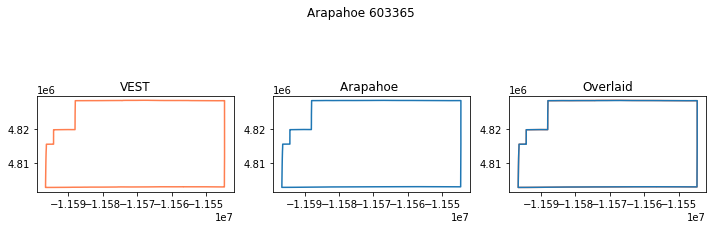

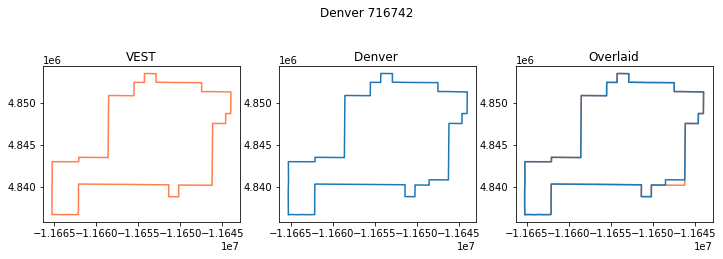

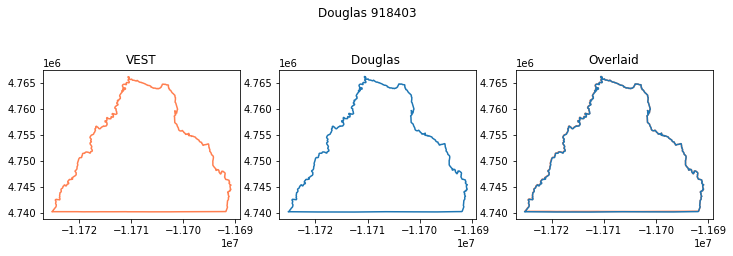

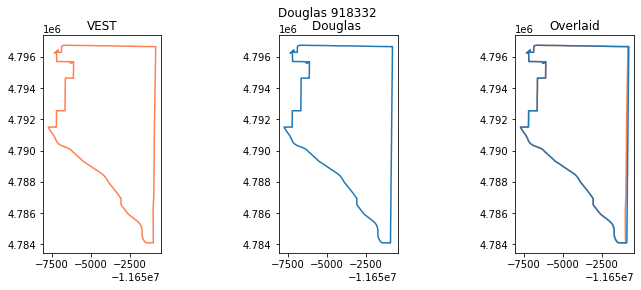

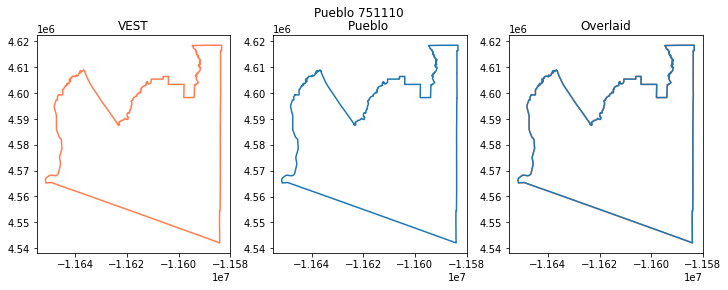

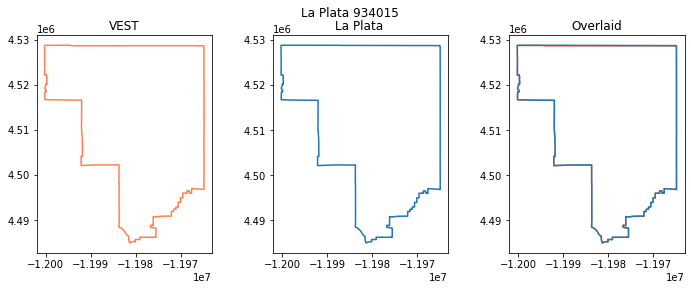

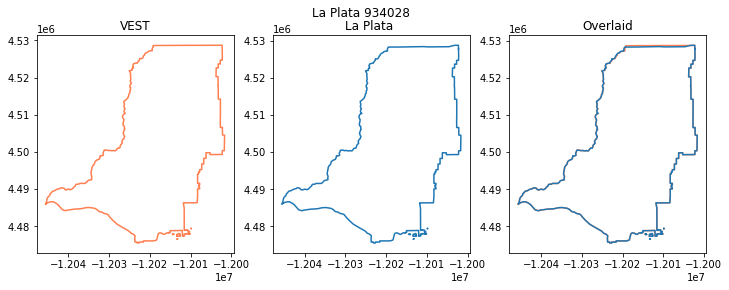

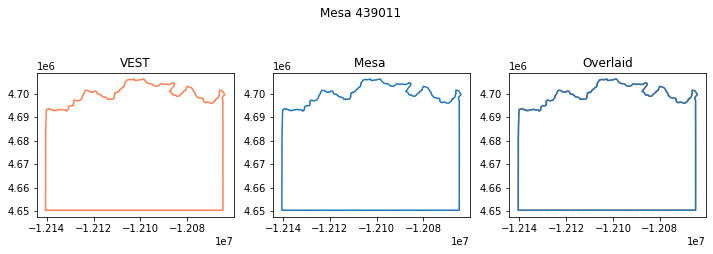

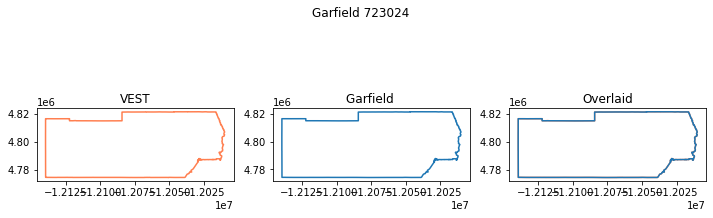

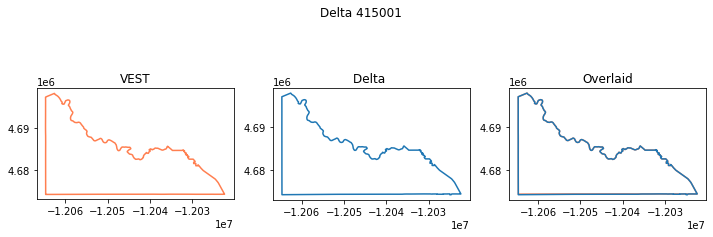

In [10]:
# these counties have significant changes, will be examined individually
skip_counties = {'Jefferson ', 'Prowers ', 'Elbert ', 'Las Animas ', 
                 'Gunnison ', 'Boulder ', 'Summit ', 'Pitkin ', 'El Paso ', 
                 'Larimer ', 'Otero '}

validated_counties = set()
county2incorrect = {}
problem_counties = set()

relevant_paths = ["raw-from-source/census_p2/" + \
                  f for f in os.listdir("raw-from-source/census_p2/")]
relevant_paths.extend(["raw-from-source/county_download/" + \
                       f for f in os.listdir("raw-from-source/county_download/")])

# we will convert this to a geodataframe at the end, but may not need to, because
# we will be joining to a geodataframe and will have to set the geometry
# to be different
shape_name_df = pd.DataFrame(columns=["VEST Name", "County", "geometry"])

for county in vest_df["COUNTY"].unique():
    
    if county in skip_counties:
        continue
    
    print(county)
    print('-' * 15)
    
    v_df = vest_df[vest_df["COUNTY"] == county].copy()
    
    try:
        c_df = get_county_shapefile(relevant_paths, county)
    except ValueError:
        print(f"No data for {county}.\n")
        continue
    
    # find the unique id for our county shapefiles
    c_field = None
    for col in c_df:
        if col == "geometry":
            continue
            
        if len(c_df[col]) == len(c_df[col].unique()):
            c_field = col
            
    if c_field is None:
        raise ValueError("No unique ID besides geometry")
            
    
    if not os.path.exists(f"county2vest_dicts/{county}"):
        county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
        f = open(f"county2vest_dicts/{county}", "wb")
        pkl.dump((county2vest, invalid_county), f)
        
    else:
        f = open(f"county2vest_dicts/{county}", "rb")
        county2vest, invalid_county = pkl.load(f)
    
    # these are the idxs that contain the geoms that we want to match 
    # with the vest names and county
    idxs = [key[1][0] for key in county2vest]
    c_df = c_df.loc[idxs, :]
    
    c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)
    
    # report all districts for which the differences are larger than 1km^2
    county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)
    
    
    # unequal geoms and geom errors, respectively 
    if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
        county2incorrect[county] = county_incorrect
        problem_counties.add(county)
    else:
        validated_counties.add(county)
    
    # there is some issue going on here. Maybe an offsetting issue?
    merge_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
    merge_data["County"] = county
    shape_name_df = pd.concat([shape_name_df, merge_data], axis=0)
        
    print()



#### We will visually validate Arapahoe, Denver, Douglas, Pueblo, La Plata, Mesa, Pitkin, Garfield, and Delta counties based on the small changes that VEST made. 

In [11]:
validated_counties.add("Arapahoe ")
validated_counties.add("Denver ")
validated_counties.add("Douglas ")
validated_counties.add("Pueblo ")
validated_counties.add("La Plata ")
validated_counties.add("Mesa ")
validated_counties.add("Garfield ")
validated_counties.add("Delta ")

problem_counties = problem_counties.difference(validated_counties)
print(problem_counties)

set()


#### Jefferson

258
321

Geoms reported unequal for Jefferson 530036
Difference in area is 1.48 km^2

Geoms reported unequal for Jefferson 530047
Difference in area is 1.18 km^2



KeyError: 'Jefferson '

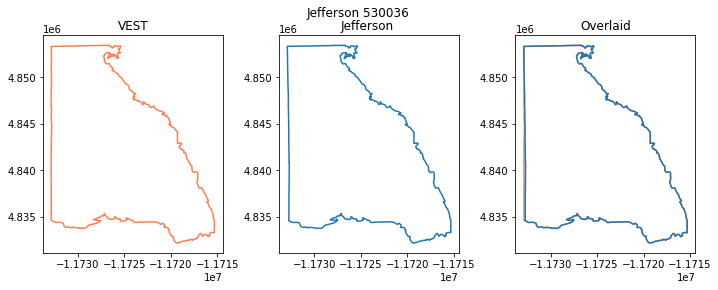

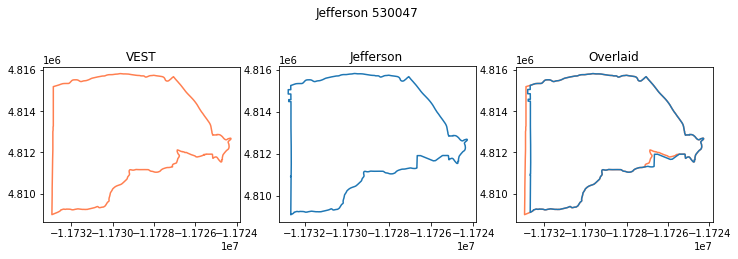

In [30]:
v_df = vest_df[vest_df["COUNTY"] == "Jefferson "].copy()

try:
    c_df = get_county_shapefile(relevant_paths, "Jefferson")
except ValueError:
    print(f"No data for {county}.\n")
    
print(len(v_df))
print(len(c_df))



# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")
    
if not os.path.exists(f"county2vest_dicts/Jefferson"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/Jefferson", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/Jefferson", "rb")
    county2vest, invalid_county = pkl.load(f)


county2vest[(49547.8356897381, (187,))] = {'Jefferson 430093'}

# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
jeff_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
jeff_data["County"] = "Jefferson "
shape_name_df = pd.concat([shape_name_df, jeff_data], axis=0)

validated_counties.add("Jefferson ")
skip_counties.remove("Jefferson ")

#### Elbert


Geoms reported unequal for Elbert 420002
Difference in area is 19.77 km^2

Geoms reported unequal for Elbert 420005
Difference in area is 19.77 km^2



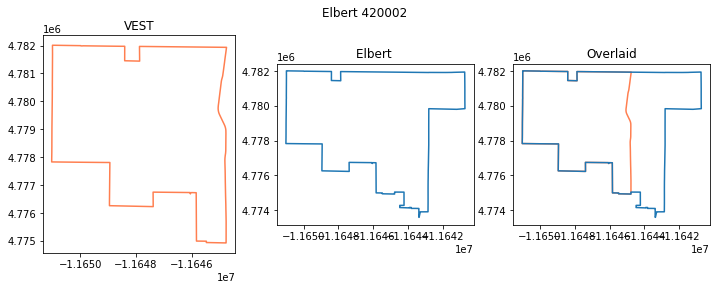

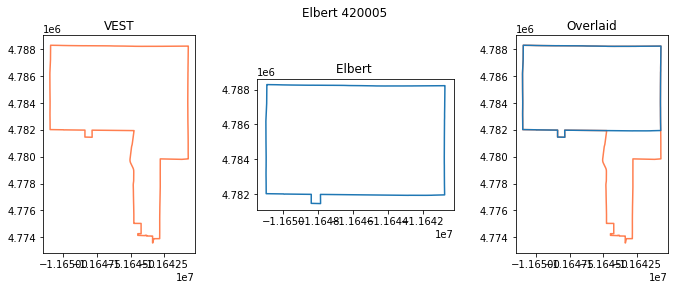

In [13]:
v_df = vest_df[vest_df["COUNTY"] == "Elbert "].copy()
    
try:
    c_df = get_county_shapefile(relevant_paths, "Elbert")
except ValueError:
    print(f"No data for {county}.\n")


# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")
    
    
if not os.path.exists(f"county2vest_dicts/Elbert"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/Elbert", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/Elbert", "rb")
    county2vest, invalid_county = pkl.load(f)


county2vest[('Elbert 2', (1,))] = {'Elbert 420002'}

# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
elbert_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
elbert_data["County"] = "Elbert "
shape_name_df = pd.concat([shape_name_df, elbert_data], axis=0)

validated_counties.add("Elbert ")

##### Elbert, two precincts seem to have swapped a boundary.

#### Larimer


Geoms reported unequal for Larimer 935417
Difference in area is 2.29 km^2

Geoms reported unequal for Larimer 135520
Difference in area is 3.25 km^2

Geoms reported unequal for Larimer 935401
Difference in area is 4.13 km^2



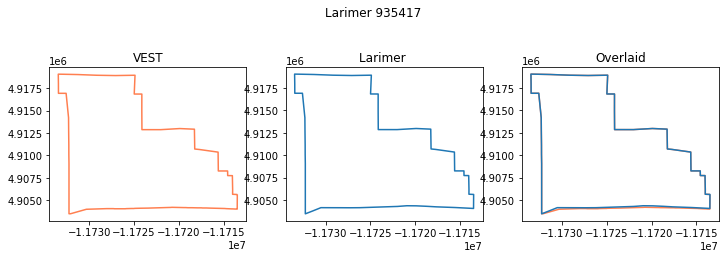

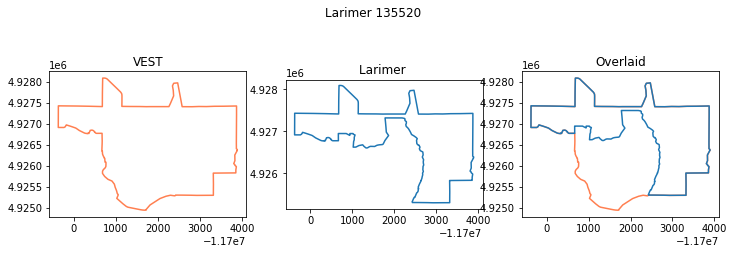

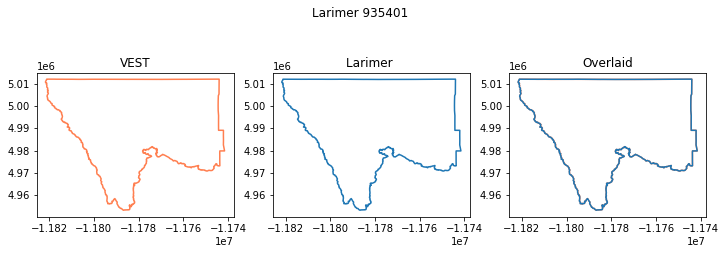

In [14]:
v_df = vest_df[vest_df["COUNTY"] == "Larimer "].copy()
    
try:
    c_df = get_county_shapefile(relevant_paths, "Larimer")
except ValueError:
    print(f"No data for {county}.\n")


# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")


if not os.path.exists(f"county2vest_dicts/Larimer"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/Larimer", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/Larimer", "rb")
    county2vest, invalid_county = pkl.load(f)


# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
larimer_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
larimer_data["County"] = "Larimer "
shape_name_df = pd.concat([shape_name_df, larimer_data], axis=0)

validated_counties.add("Larimer ")

#### Prowers 


Geoms reported unequal for Prowers 450005
Difference in area is 3.95 km^2

Geoms reported unequal for Prowers 450011
Difference in area is 1.33 km^2



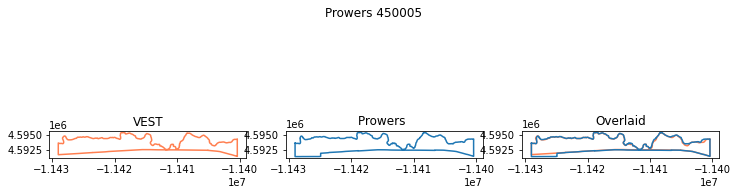

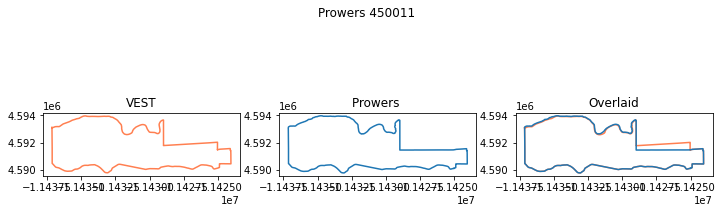

In [15]:
v_df = vest_df[vest_df["COUNTY"] == "Prowers "].copy()
    
try:
    c_df = get_county_shapefile(relevant_paths, "Prowers")
except ValueError:
    print(f"No data for {county}.\n")


# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")
    
if not os.path.exists(f"county2vest_dicts/Prowers"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/Prowers", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/Prowers", "rb")
    county2vest, invalid_county = pkl.load(f)


county2vest[('Prowers 005', (4,))] = {'Prowers 450005'}

# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
prowers_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
prowers_data["County"] = "Prowers "
shape_name_df = pd.concat([shape_name_df, prowers_data], axis=0)

validated_counties.add("Prowers ")

#### Slight boundary redraws, but we will consider good!

#### Gunnison 


Geoms reported unequal for Gunnison 126004
Difference in area is 7.02 km^2

Geoms reported unequal for Gunnison 926008
Difference in area is 21.06 km^2

Geoms reported unequal for Gunnison 926013
Difference in area is 21.04 km^2

Geoms reported unequal for Gunnison 126006
Difference in area is 1.53 km^2

Geoms reported unequal for Gunnison 126007
Difference in area is 1.53 km^2

Geoms reported unequal for Gunnison 126005
Difference in area is 7.18 km^2



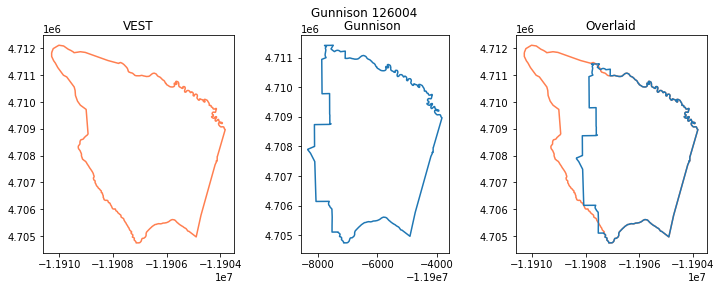

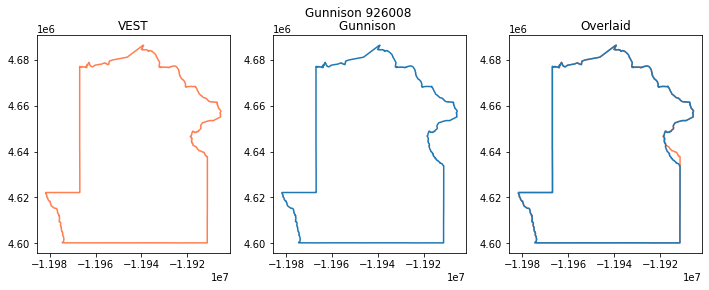

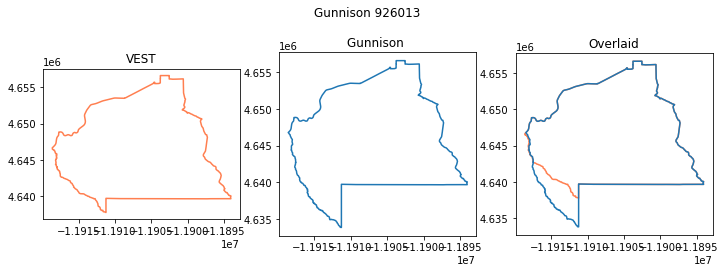

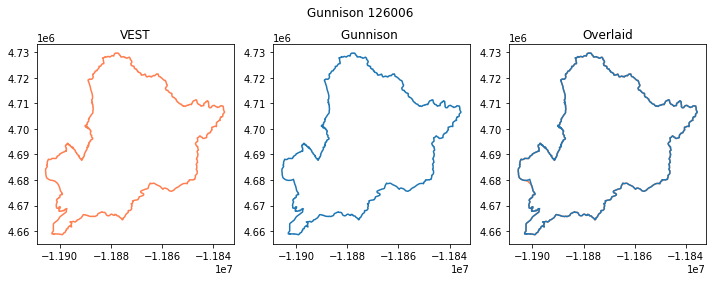

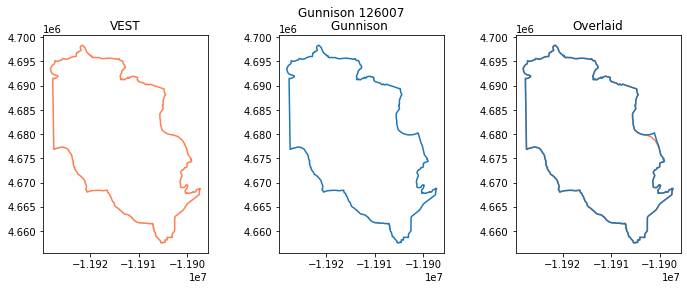

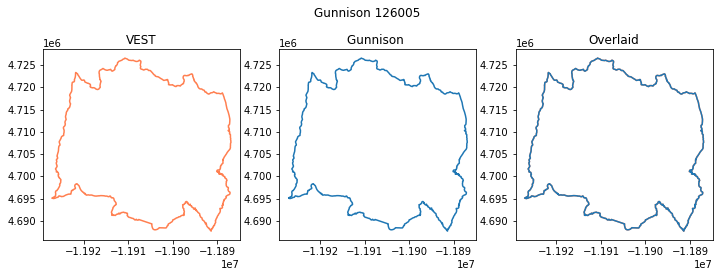

In [16]:
v_df = vest_df[vest_df["COUNTY"] == "Gunnison "].copy()
    
try:
    c_df = get_county_shapefile(relevant_paths, "Gunnison")
except ValueError:
    print(f"No data for {county}.\n")


# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")
    
if not os.path.exists(f"county2vest_dicts/Gunnison"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/Gunnison", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/Gunnison", "rb")
    county2vest, invalid_county = pkl.load(f)


county2vest[('Gunnison 005', (4,))] = {'Gunnison 126005'}

# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
gunn_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
gunn_data["County"] = "Gunnison "
shape_name_df = pd.concat([shape_name_df, gunn_data], axis=0)

validated_counties.add("Gunnison ")

##### VEST has made some larger changes, would be good to verify. 

#### Pitkin 


Geoms reported unequal for Pitkin 149001
Difference in area is 1.34 km^2

Geoms reported unequal for Pitkin 149009
Difference in area is 31.04 km^2

Geoms reported unequal for Pitkin 149010
Difference in area is 6.32 km^2



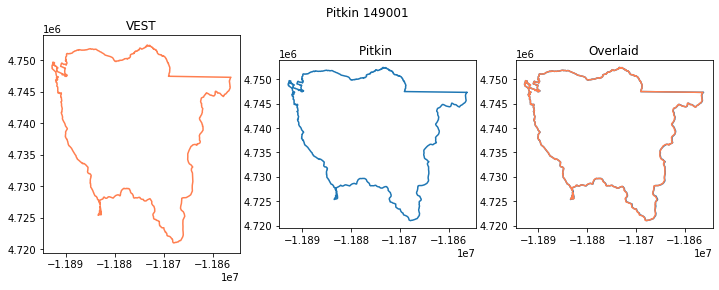

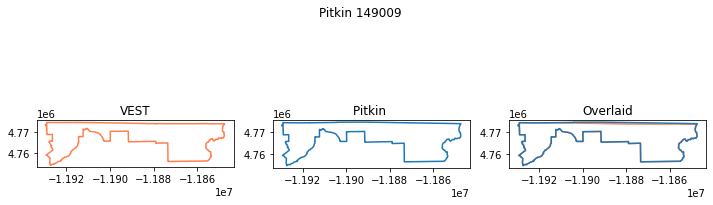

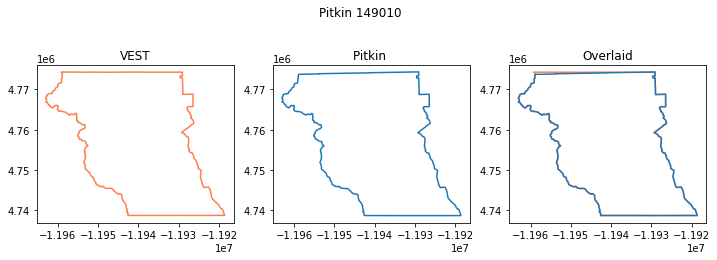

In [17]:
v_df = vest_df[vest_df["COUNTY"] == "Pitkin "].copy()
    
try:
    c_df = get_county_shapefile(relevant_paths, "Pitkin")
except ValueError:
    print(f"No data for {county}.\n")


# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")
    
if not os.path.exists(f"county2vest_dicts/Pitkin"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/Pitkin", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/Pitkin", "rb")
    county2vest, invalid_county = pkl.load(f)    
    

# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
pitkin_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
pitkin_data["County"] = "Pitkin "
shape_name_df = pd.concat([shape_name_df, pitkin_data], axis=0)

validated_counties.add("Pitkin ")

#### Otero 

In [18]:
v_df = vest_df[vest_df["COUNTY"] == "Otero "].copy()
    
try:
    c_df = get_county_shapefile(relevant_paths, "Otero")
except ValueError:
    print(f"No data for {county}.\n")


# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")
    
if not os.path.exists(f"county2vest_dicts/Otero"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/Otero", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/Otero", "rb")
    county2vest, invalid_county = pkl.load(f)


county2vest[('Otero 004', (16,))] = {'Otero 745004'}
# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
otero_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
otero_data["County"] = "Otero "
shape_name_df = pd.concat([shape_name_df, otero_data], axis=0)




All shapefiles match for Otero  county.


#### Summit


Geoms reported unequal for Summit 159012
Difference in area is 13.95 km^2

Geoms reported unequal for Summit 159008
Difference in area is 22.42 km^2



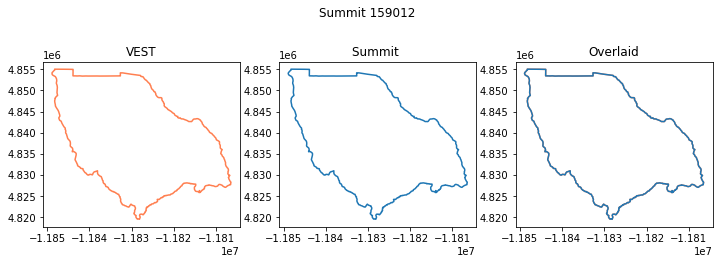

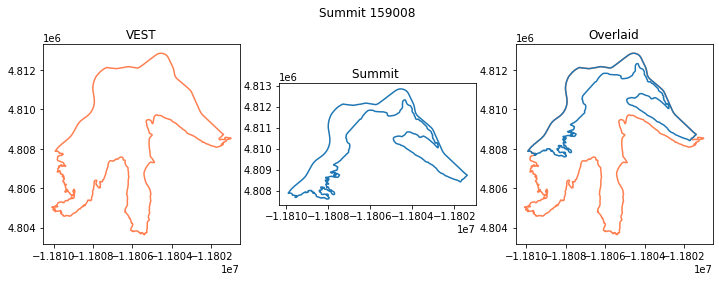

In [19]:
v_df = vest_df[vest_df["COUNTY"] == "Summit "].copy()
    
try:
    c_df = get_county_shapefile(relevant_paths, "Summit")
except ValueError:
    print(f"No data for {county}.\n")


# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")

if not os.path.exists(f"county2vest_dicts/Summit"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/Summit", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/Summit", "rb")
    county2vest, invalid_county = pkl.load(f)

# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
summit_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
summit_data["County"] = "Summit "
shape_name_df = pd.concat([shape_name_df, summit_data], axis=0)


#### Boulder


Geoms reported unequal for Boulder 107918
Difference in area is 1.87 km^2



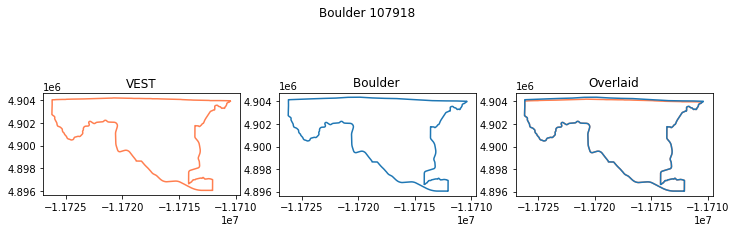

In [20]:
v_df = vest_df[vest_df["COUNTY"] == "Boulder "].copy()
    
try:
    c_df = get_county_shapefile(relevant_paths, "Boulder")
except ValueError:
    print(f"No data for {county}.\n")


# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")
    
    
if not os.path.exists(f"county2vest_dicts/Boulder"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/Boulder", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/Boulder", "rb")
    county2vest, invalid_county = pkl.load(f)


county2vest[(13240.84040370923, (230,))] = {'Boulder 007809'}
county2vest[(19490.756085939734, (229,))] = {'Boulder 107618'}
county2vest[(21405.452134136838, (236,))] = {'Boulder 207600'}
county2vest[(12140.42110847775, (233,))] = {'Boulder 007822'}
county2vest[(12195.668704676853, (235,))] = {'Boulder 207307'}

# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
boulder_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
boulder_data["County"] = "Boulder "
shape_name_df = pd.concat([shape_name_df, boulder_data], axis=0)

validated_counties.add("Boulder ")

#### El Paso


Geoms reported unequal for El Paso 021740
Difference in area is 2.76 km^2



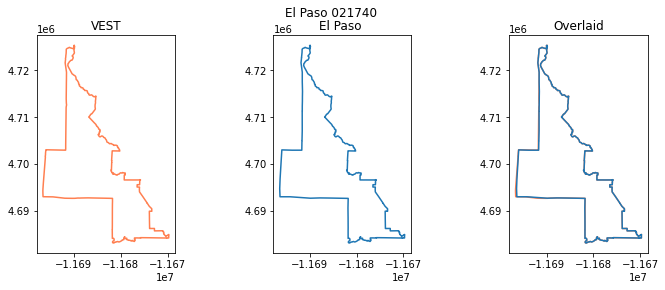

In [21]:
v_df = vest_df[vest_df["COUNTY"] == "El Paso "].copy()
    
try:
    c_df = get_county_shapefile(relevant_paths, "El Paso")
except ValueError:
    print(f"No data for {county}.\n")


# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")
    
if not os.path.exists(f"county2vest_dicts/El Paso"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/El Paso", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/El Paso", "rb")
    county2vest, invalid_county = pkl.load(f)


# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
el_paso_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
el_paso_data["County"] = "El Paso "
shape_name_df = pd.concat([shape_name_df, el_paso_data], axis=0)

validated_counties.add("El Paso ")

#### Las Animas had numerous changes, we won't be able to validate each one here. 

('Las Animas 011', (10,)) has multiple assignments: {'Las Animas 436014', 'Las Animas 436011', 'Las Animas 436013'}

Geoms reported unequal for Las Animas 436009
Difference in area is 93.87 km^2

Geoms reported unequal for Las Animas 436014
Difference in area is 3.3 km^2

Geoms reported unequal for Las Animas 436013
Difference in area is 2.28 km^2

Exception thrown for geom_almost_equals on Las Animas 436015

Geoms reported unequal for Las Animas 436003
Difference in area is 28.77 km^2

Geoms reported unequal for Las Animas 436005
Difference in area is 4.84 km^2

Geoms reported unequal for Las Animas 436002
Difference in area is 120.63 km^2

Geoms reported unequal for Las Animas 436008
Difference in area is 1.26 km^2

Geoms reported unequal for Las Animas 436001
Difference in area is 148.34 km^2

Geoms reported unequal for Las Animas 436016
Difference in area is 2.27 km^2

Exception thrown for geom_almost_equals on Las Animas 436011

Geoms reported unequal for Las Animas 436012
Differe

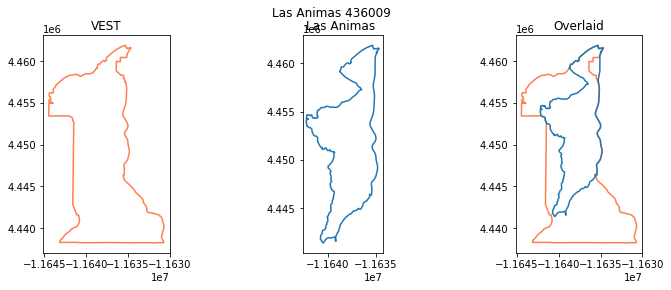

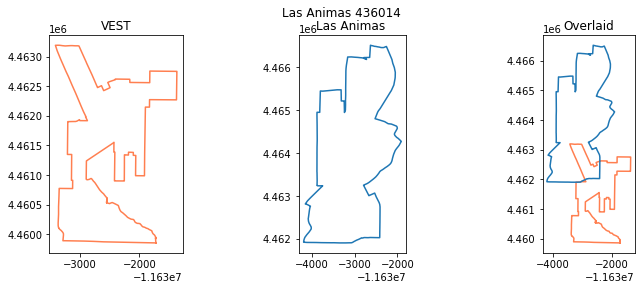

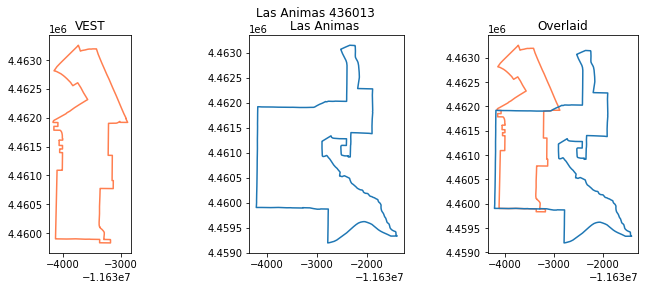

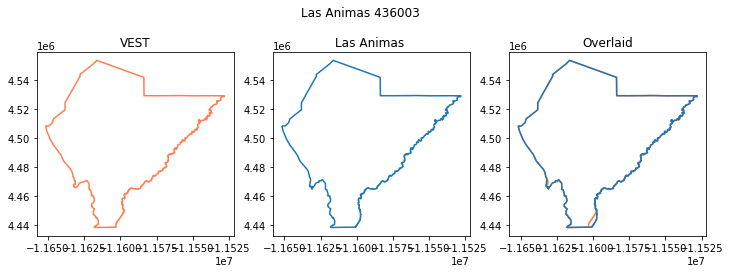

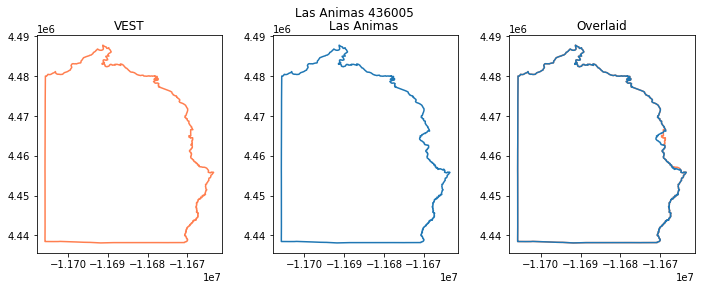

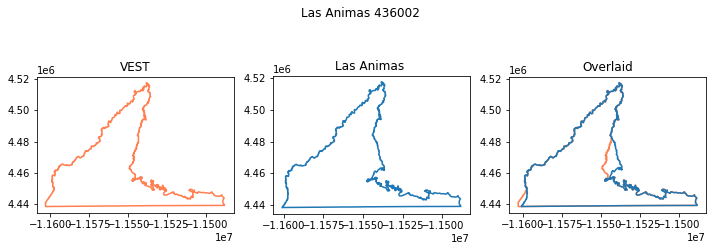

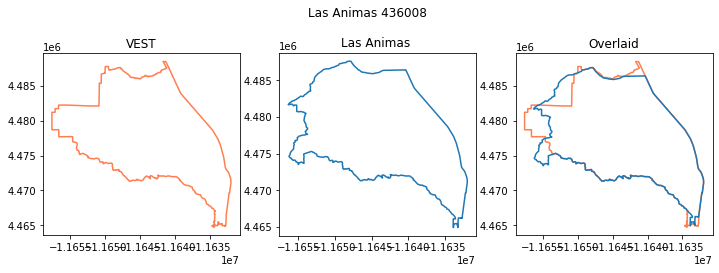

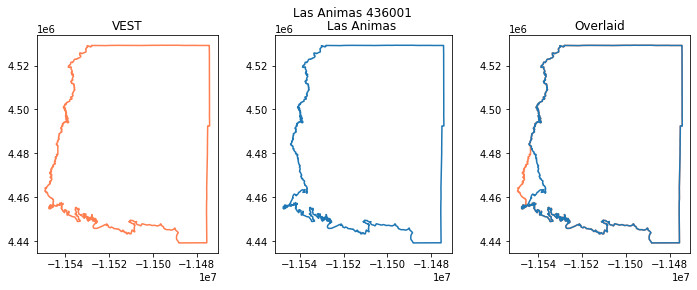

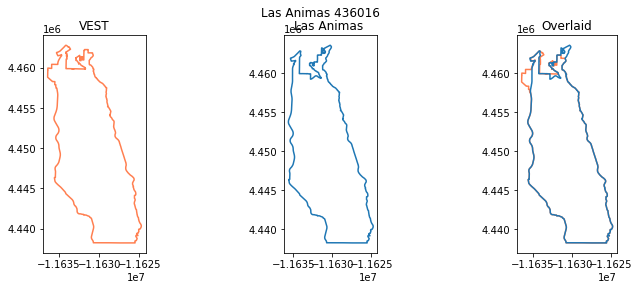

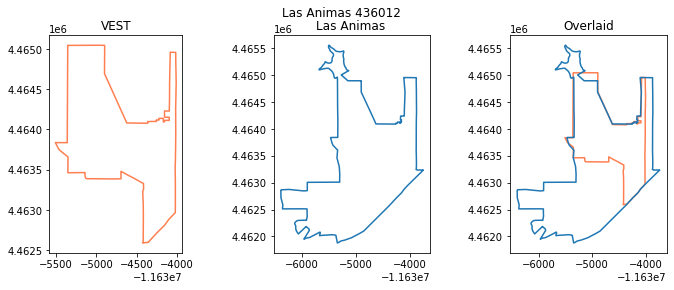

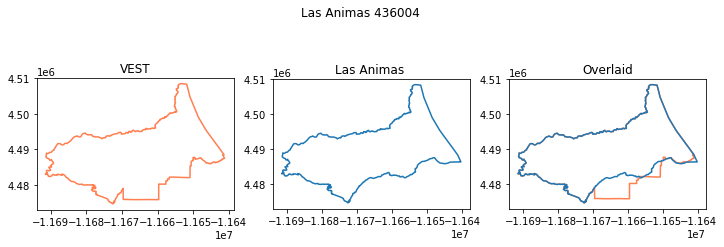

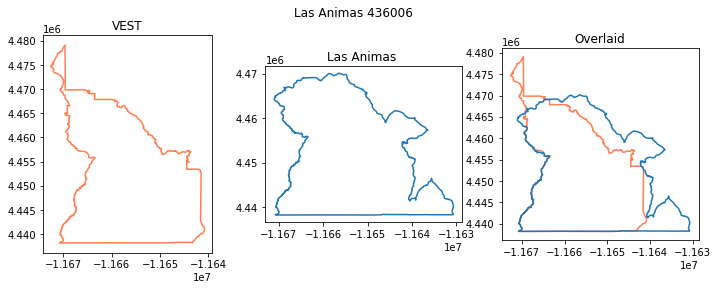

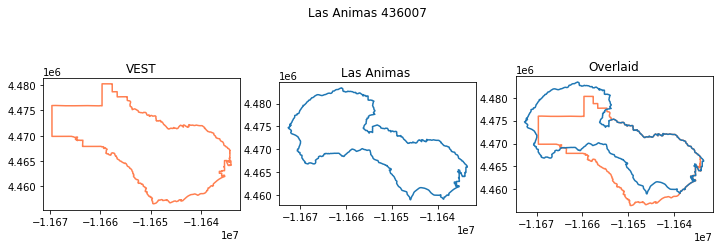

In [22]:
v_df = vest_df[vest_df["COUNTY"] == "Las Animas "].copy()
    
try:
    c_df = get_county_shapefile(relevant_paths, "Las Animas ")
except ValueError:
    print(f"No data for {county}.\n")


# find the unique id for our county shapefiles
c_field = None
for col in c_df:
    if col == "geometry":
        continue

    if len(c_df[col]) == len(c_df[col].unique()):
        c_field = col

if c_field is None:
    raise ValueError("No unique ID besides geometry")

if not os.path.exists(f"county2vest_dicts/Las Animas"):
    county2vest, invalid_county = assign_names_by_geoms(v_df, c_df, "ID", c_field)
    f = open(f"county2vest_dicts/Las Animas", "wb")
    pkl.dump((county2vest, invalid_county), f)

else:
    f = open(f"county2vest_dicts/Las Animas", "rb")
    county2vest, invalid_county = pkl.load(f)
    
county2vest[('Las Animas 016', (14,))] = {'Las Animas 436016'}
county2vest[('Las Animas 010', (9,))] = {'Las Animas 436010'}
county2vest[('Las Animas 006', (5,))] = {'Las Animas 436006'}
county2vest[('Las Animas 003', (2,))] = {'Las Animas 436003'}
county2vest[('Las Animas 007', (6,))] = {'Las Animas 436007'}
county2vest[('Las Animas 012', (11,))] = {'Las Animas 436012'}
county2vest[('Las Animas 014', (13,))] = {'Las Animas 436013'}

# these are the idxs that contain the geoms that we want to match 
# with the vest names and county
idxs = [key[1][0] for key in county2vest]
c_df = c_df.loc[idxs, :]

c_df, county_multiple = add_merge_column(c_df, county2vest, c_field)

# report all districts for which the differences are larger than 1km^2
county_incorrect = validate_assigned_geoms(v_df, c_df, invalid_county, "ID", c_field, tolerance=1)


# unequal geoms and geom errors, respectively 
if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
    county2incorrect[county] = county_incorrect
    problem_counties.add(county)
else:
    validated_counties.add(county)

# there is some issue going on here. Maybe an offsetting issue?
la_data = pd.DataFrame(data = {"VEST Name" : c_df["MERGE"], "geometry" : c_df["geometry"]})
la_data["County"] = "Las Animas "
shape_name_df = pd.concat([shape_name_df, la_data], axis=0)



### Final merge and comparison:

In [23]:
# Combine geometries with merged_df, which contains the election results
shape_name_df.rename(columns={"VEST Name" : "ID"}, inplace=True)

# all differences in ID counts can be attributed to Las Animas county
display(merged_df[~merged_df["ID"].isin(shape_name_df["ID"])])

,STATEFP,COUNTYFP,VTDST,NAME,PRECINCT,G18GOVDPOL_x,G18GOVRSTA_x,G18GOVLHEL_x,G18GOVOHAM_x,G18ATGDWEI_x,G18ATGRBRA_x,G18ATGLROB_x,G18SOSDGRI_x,G18SOSRWIL_x,G18SOSCCAM_x,G18SOSOHUB_x,G18TREDYOU_x,G18TRERWAT_x,G18TRECKIL_x,G18RGTDSMI_x,G18RGTRMON_x,G18RGTLTRE_x,G18RGTOOTW_x,geometry,COUNTY,ID,G18SOSCCAM_y,G18GOVOHAM_y,G18SOSOHUB_y,G18TRERWAT_y,G18RGTOOTW_y,G18TREDYOU_y,G18ATGRBRA_y,G18TRECKIL_y,G18RGTLTRE_y,G18GOVDPOL_y,G18SOSDGRI_y,G18RGTRMON_y,G18RGTDSMI_y,G18ATGDWEI_y,G18GOVLHEL_y,G18GOVRSTA_y,G18SOSRWIL_y,G18ATGLROB_y
3126,08,071,071015,Las Animas 015,4356436015,338,218,13,9,324,239,16,338,218,18,4,332,224,16,317,228,19,2,"POLYGON ((-11635668.283 4462078.521, -11635693...",Las Animas,Las Animas 436015,18,9,4,224,2,332,239,16,19,338,338,228,317,324,13,218,218,16
3130,08,071,071011,Las Animas 011,4356436011,322,149,17,11,325,150,17,350,128,17,5,332,138,24,310,154,13,12,"POLYGON ((-11633311.468 4465222.020, -11633311...",Las Animas,Las Animas 436011,17,11,5,138,12,332,150,24,13,322,350,154,310,325,17,149,128,17


In [24]:
final_df = merged_df.merge(shape_name_df, on="ID", how="left")

In [25]:
print(f"There are {len(vest_df)} VEST precincts.")
print(f"There are {len(merged_df)} VEST precincts.")
print(f"There are {len(final_df)} final_df precincts.")

interesting_cols = [col[:-2] for col in final_df if col.endswith("_x") and col != "geometry_x"]
print(f"All precincts have correct vote totals:", validater_row_vect(merged_df, "ID", interesting_cols)[0])


There are 3136 VEST precincts.
There are 3136 VEST precincts.
There are 3136 final_df precincts.
All precincts have correct vote totals: True


In [26]:
vest_geoms = gp.GeoSeries(final_df["geometry_x"])
recreated_geoms = gp.GeoSeries(final_df["geometry_y"])

final_df["Diff area"] = np.abs(vest_geoms.area.to_numpy() - \
                               recreated_geoms.area.to_numpy()) / 1e6

print(f"There are {len(final_df)} VEST precincts.")
print(f"{len(vest_geoms[vest_geoms.geom_almost_equals(recreated_geoms, decimal=0)])} have shapefiles identical to the raw data.")

small_error = len(final_df[final_df["Diff area"] < .1])
medium_error = len(final_df[final_df["Diff area"] < 1])

print(f'{round(small_error / len(final_df) * 100, 1)} percent have differences of less than .1 km^2 -> {small_error} precincts. ')
print(f'{round(medium_error/ len(final_df) * 100, 1)} percent have differences of less than 1 km^2 -> {medium_error} precincts')


There are 3136 VEST precincts.
1294 have shapefiles identical to the raw data.
95.1 percent have differences of less than .1 km^2 -> 2981 precincts. 
98.5 percent have differences of less than 1 km^2 -> 3089 precincts


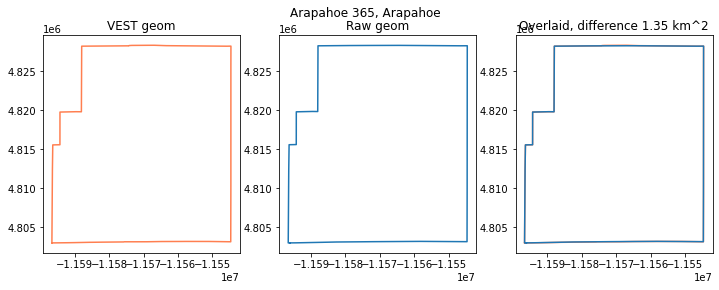

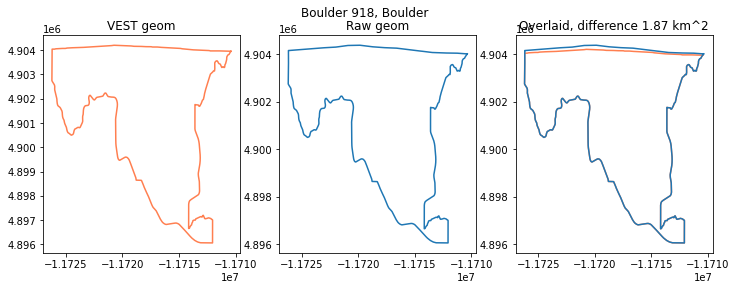

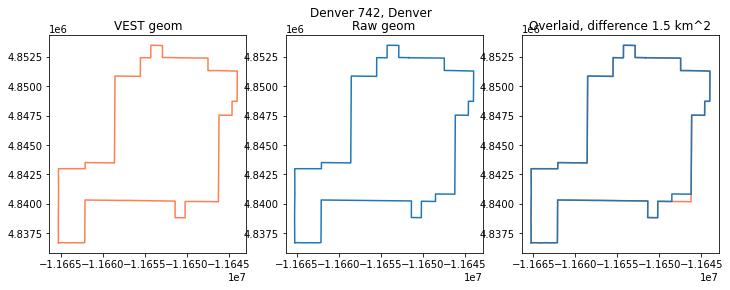

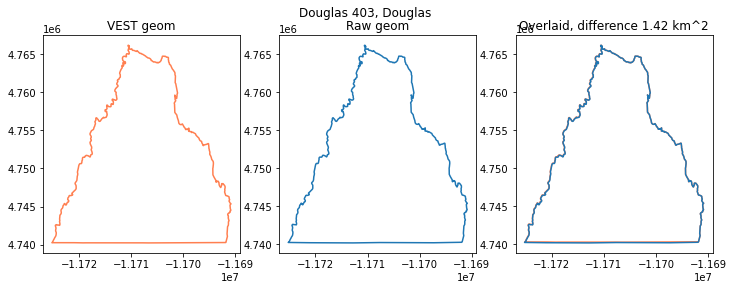

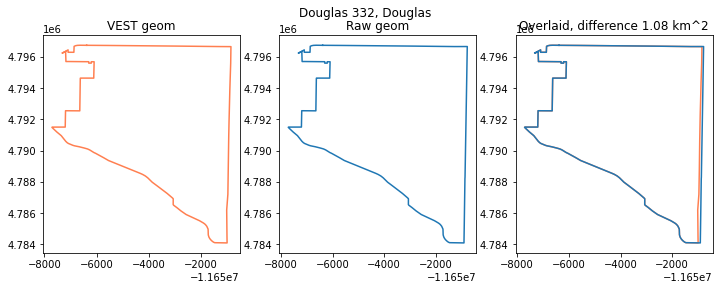

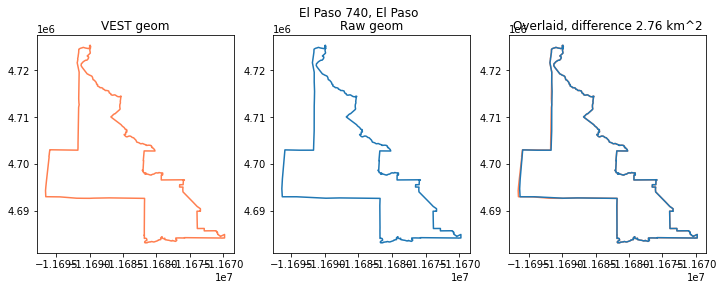

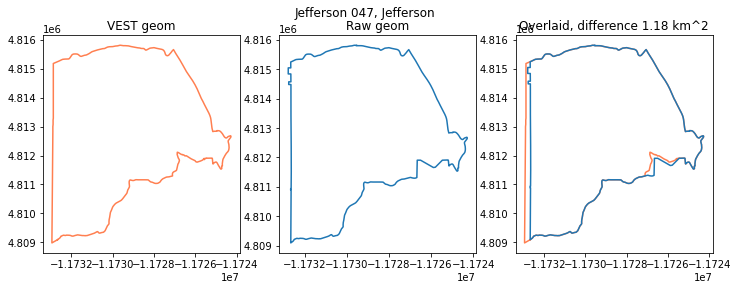

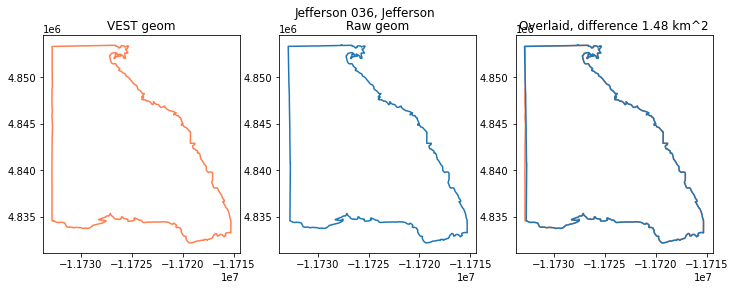

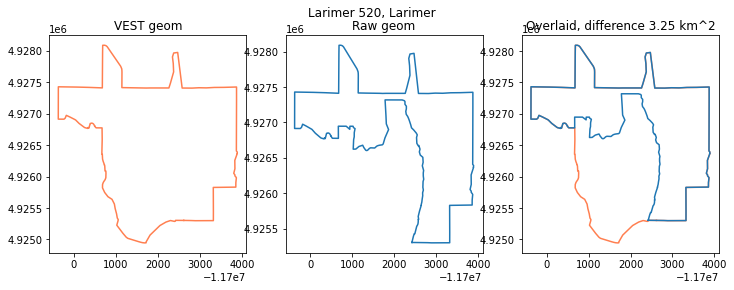

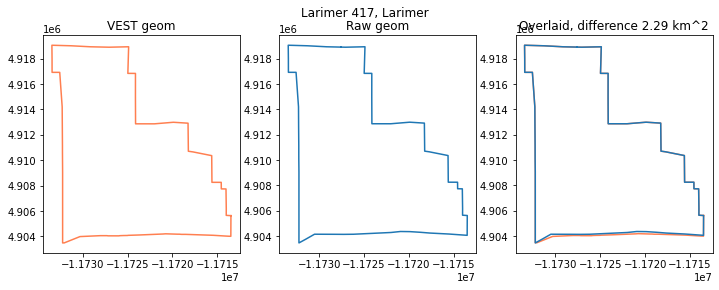

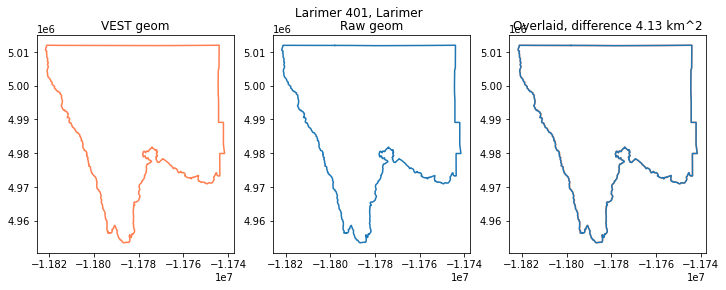

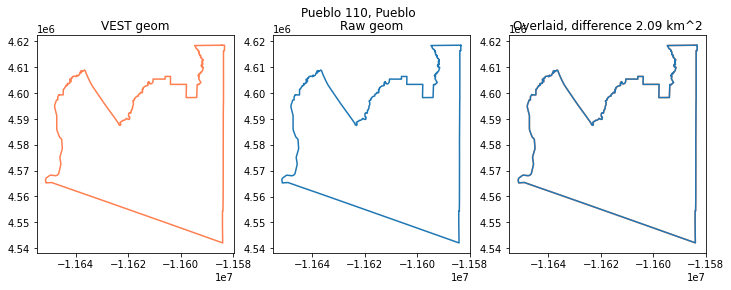

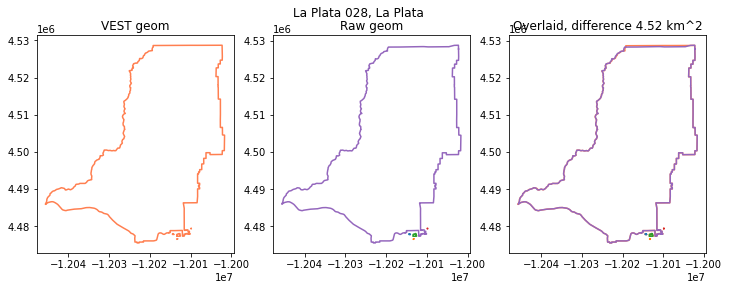

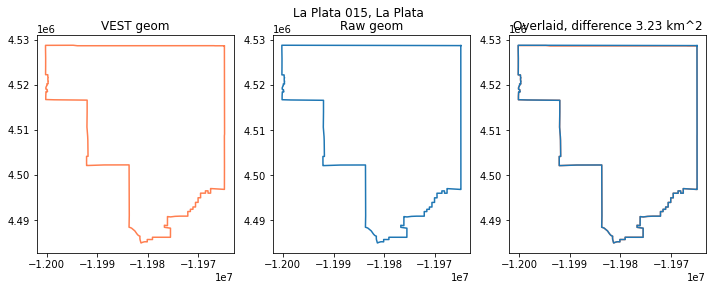

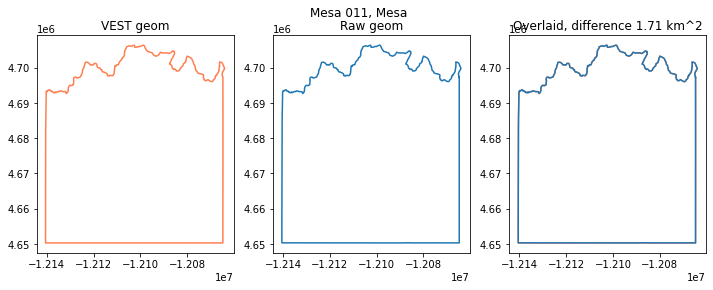

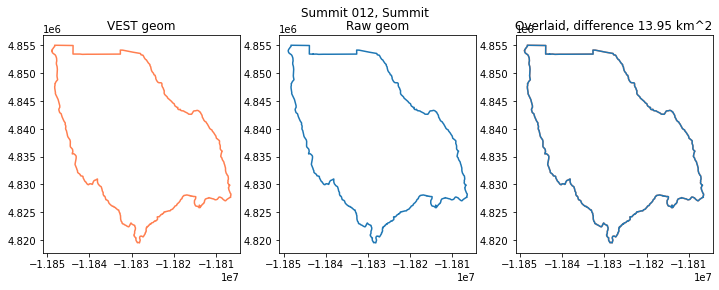

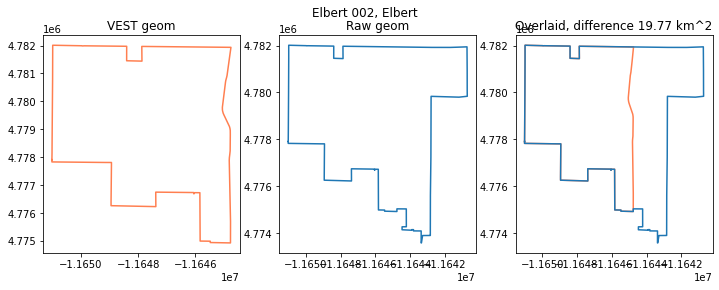

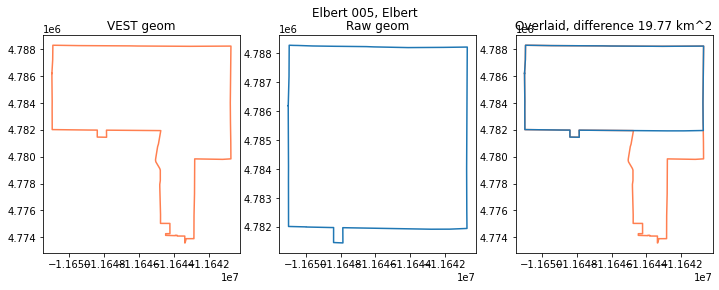

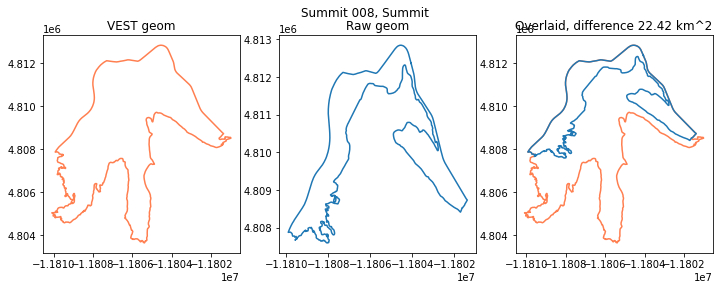

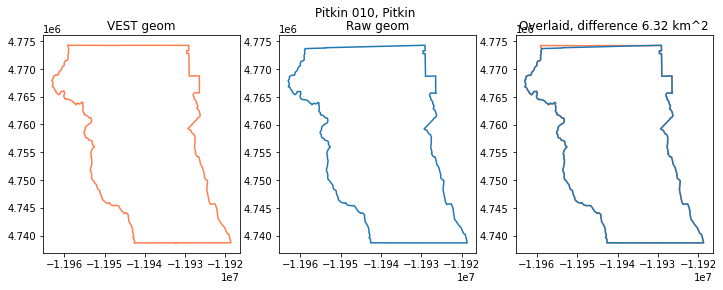

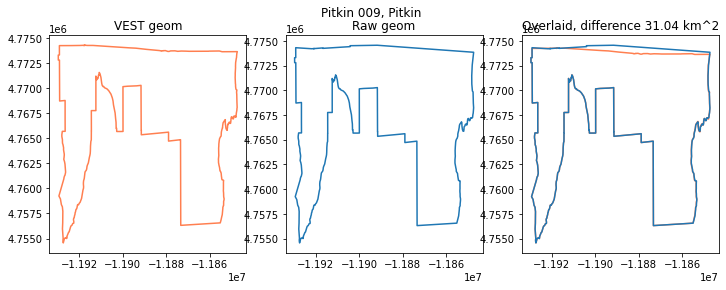

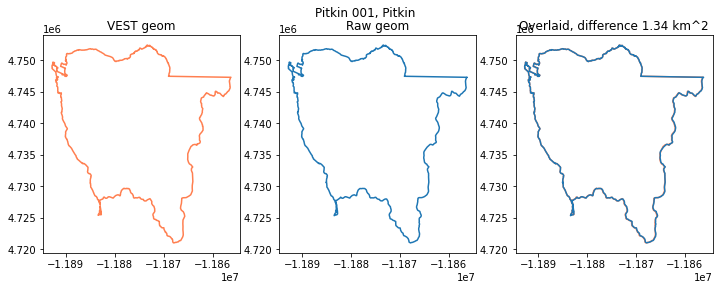

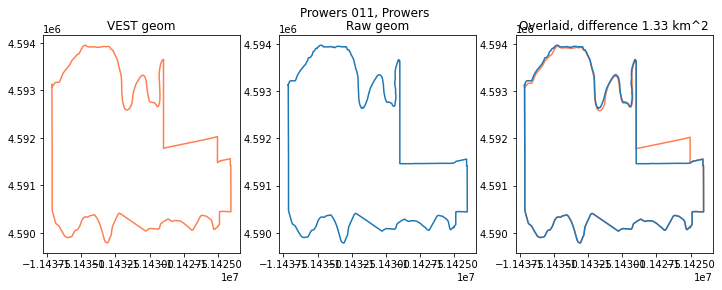

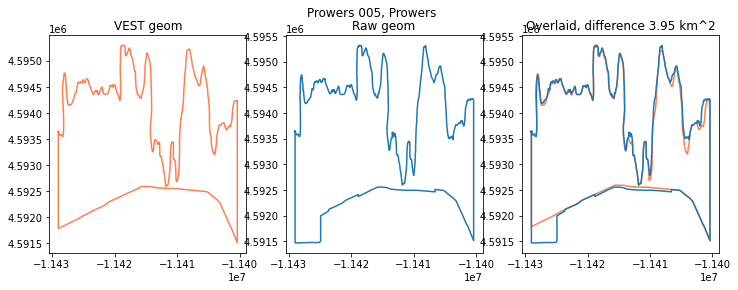

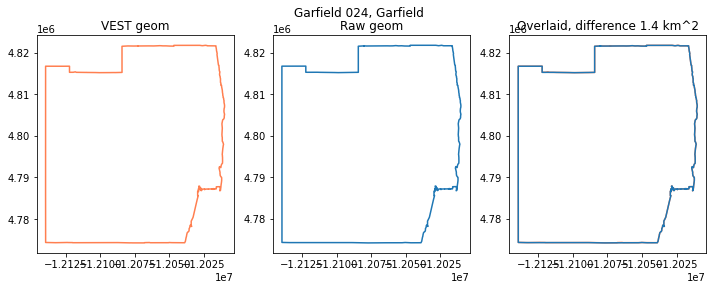

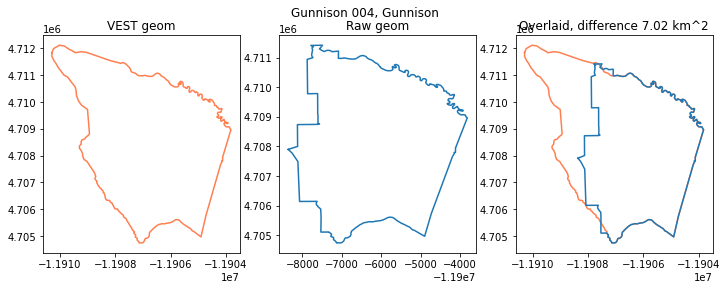

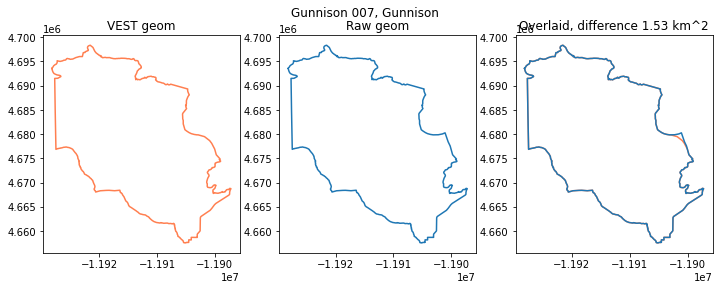

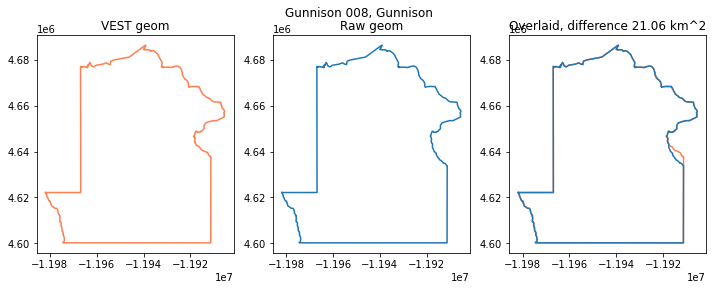

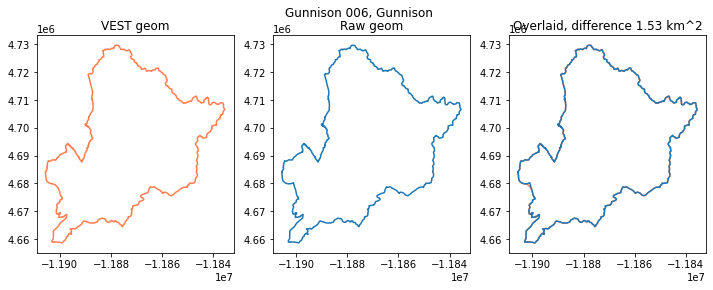

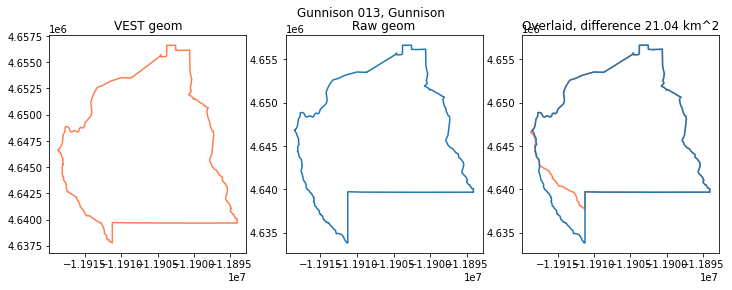

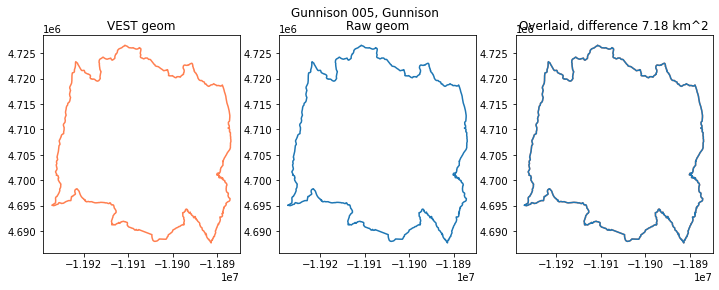

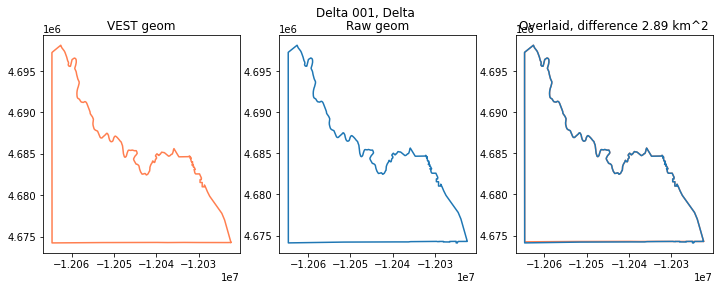

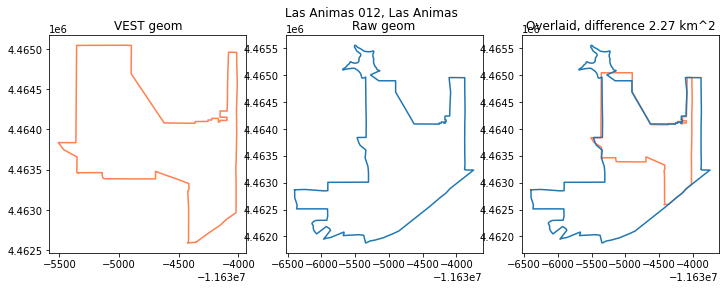

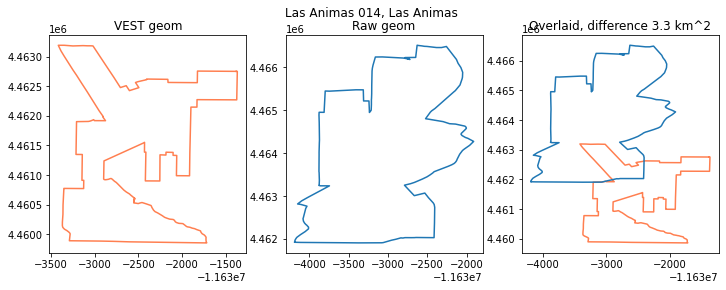

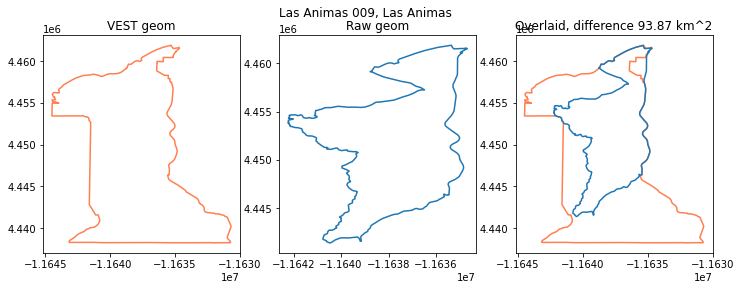

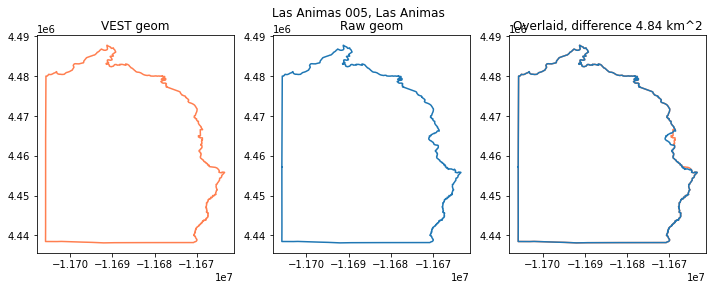

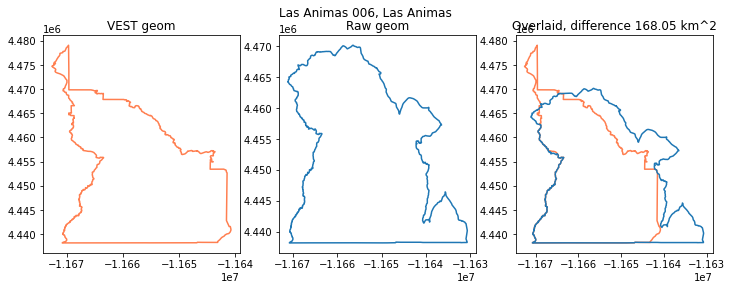

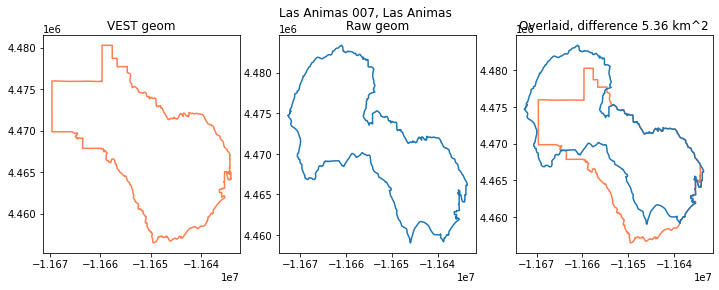

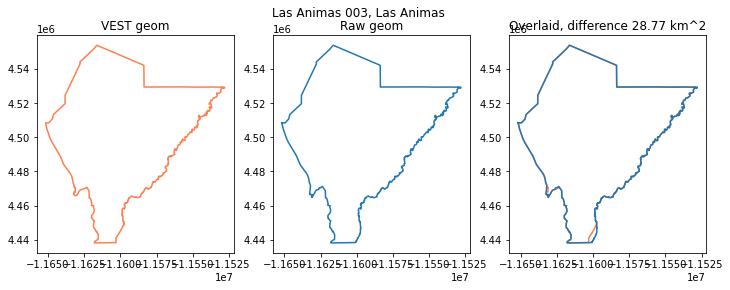

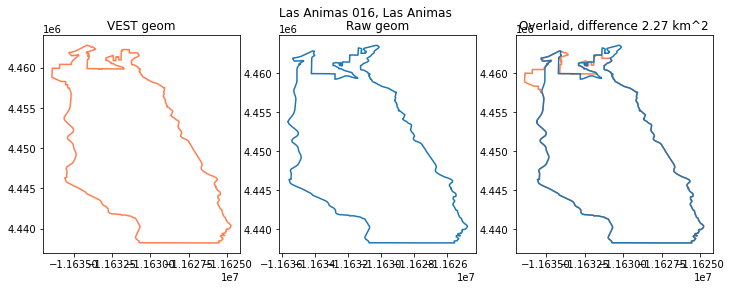

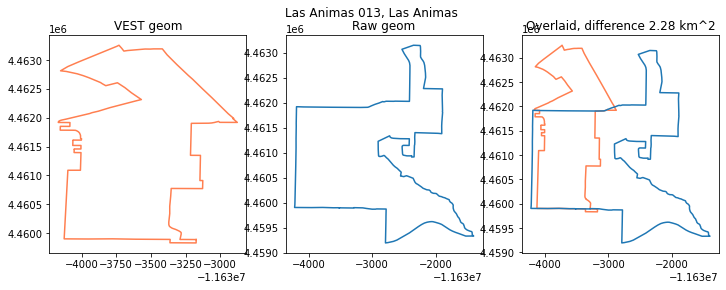

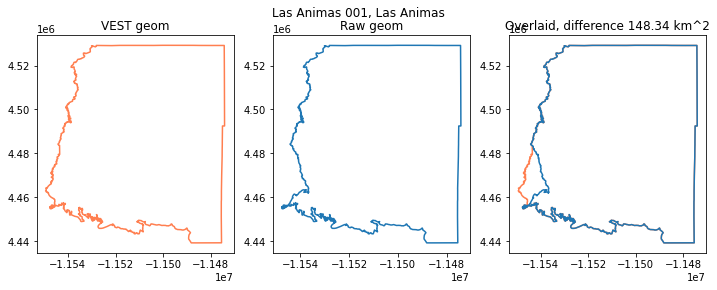

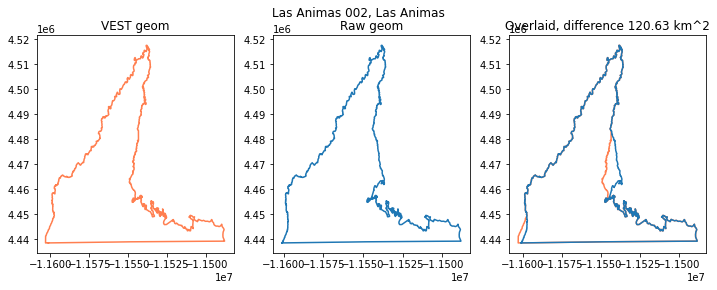

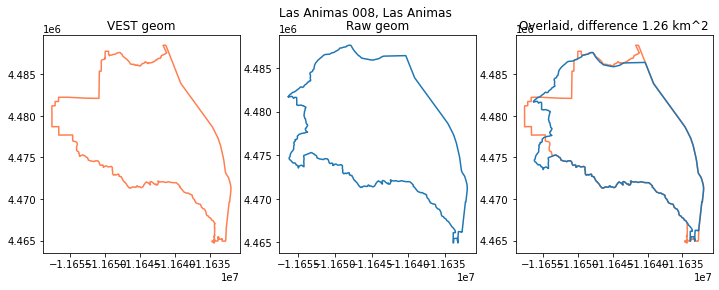

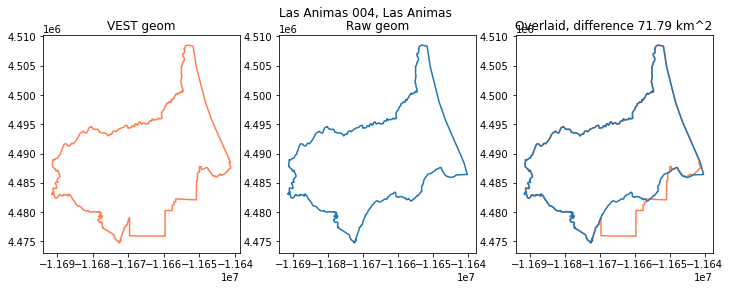

In [27]:
# here are all the precincts with larger shapefile differences
altered_vest_shapefiles = final_df[final_df["Diff area"] > 1]
vest_different = []

for i in range(len(altered_vest_shapefiles)):
    row = altered_vest_shapefiles.iloc[i]
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    v_geom = row["geometry_x"]
    raw_geom = row["geometry_y"]
    
    try:
        ax[0].plot(*v_geom.exterior.xy, color="Coral")
    except AttributeError:
        for g in v_geom.geoms:
            ax[0].plot(*g.exterior.xy, color="Coral")
            
    try:
        ax[2].plot(*v_geom.exterior.xy, color="Coral")
    except AttributeError:
        for g in v_geom.geoms:
            ax[2].plot(*g.exterior.xy, color="Coral")
            
    try:
        ax[2].plot(*raw_geom.exterior.xy)
    except AttributeError:
        for g in raw_geom.geoms:
            ax[2].plot(*g.exterior.xy)
            
    try:
        ax[1].plot(*raw_geom.exterior.xy)
    except AttributeError:
        for g in raw_geom.geoms:
            ax[1].plot(*g.exterior.xy)
            
    ax[0].set_title("VEST geom")
    ax[1].set_title("Raw geom")
    ax[2].set_title(f"Overlaid, difference {round(row['Diff area'], 2)} km^2")
    
    fig.suptitle(row["NAME"] + ", " + row["COUNTY"])
    vest_different.append(row["NAME"] + ", " + row["COUNTY"])


In [28]:
for v in [elem.split(',')[0] for elem in vest_different]:
    print(v)

Arapahoe 365
Boulder 918
Denver 742
Douglas 403
Douglas 332
El Paso 740
Jefferson 047
Jefferson 036
Larimer 520
Larimer 417
Larimer 401
Pueblo 110
La Plata 028
La Plata 015
Mesa 011
Summit 012
Elbert 002
Elbert 005
Summit 008
Pitkin 010
Pitkin 009
Pitkin 001
Prowers 011
Prowers 005
Garfield 024
Gunnison 004
Gunnison 007
Gunnison 008
Gunnison 006
Gunnison 013
Gunnison 005
Delta 001
Las Animas 012
Las Animas 014
Las Animas 009
Las Animas 005
Las Animas 006
Las Animas 007
Las Animas 003
Las Animas 016
Las Animas 013
Las Animas 001
Las Animas 002
Las Animas 008
Las Animas 004
